ANIMELENS : Proyek Klasifikasi Gambar Anime

# Import Library

In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cv2
from pathlib import Path
import os.path
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import tensorflow as tf
print(tf.__version__)  # versi tensorflow

2.18.0


In [3]:
import numpy as np
print(np.__version__)  # versi numpy

2.0.2


# Data Preparation

In [4]:
!pip install gdown

!gdown --folder https://drive.google.com/drive/folders/1LG5vfTLFFag7hVEyphNt3gbETOtZntCH?usp=sharing

Retrieving folder contents
Processing file 1meDwLIHAfX3oYcayHJbk2_MEA6qFHBGx AnimeLens_perframe_clean.rar
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1meDwLIHAfX3oYcayHJbk2_MEA6qFHBGx
From (redirected): https://drive.google.com/uc?id=1meDwLIHAfX3oYcayHJbk2_MEA6qFHBGx&confirm=t&uuid=64b28e21-18ec-4043-a1c9-7c91ddce22c5
To: /content/Clean_testing/AnimeLens_perframe_clean.rar
100% 846M/846M [00:07<00:00, 115MB/s]
Download completed


In [5]:
!pip install rarfile

In [6]:
import rarfile
extract_dir = "/content/Clean_testing"
os.makedirs(extract_dir, exist_ok=True)

try:
    with rarfile.RarFile("/content/Clean_testing/AnimeLens_perframe_clean.rar", 'r') as rar_ref:
        rar_ref.extractall(extract_dir)
    print(f"Successfully extracted /content/Capstone/AnimeLens.rar to {extract_dir}")
except rarfile.BadRarFile:
    print("Error: The file is not a valid RAR archive or is corrupted.")
except FileNotFoundError:
    print("Error: The file /content/Capstone/AnimeLens.rar was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted /content/Capstone/AnimeLens.rar to /content/Clean_testing


In [7]:
# Path ke folder utama dataset
Dataset_dir = '/content/Clean_testing/AnimeLens_perframe_clean'

# Inisialisasi list untuk menyimpan informasi
file_name = []
labels = []
full_path = []
widths = []
heights = []
formats = []

# Looping melalui seluruh file di folder dan subfolder
for path, subdirs, files in os.walk(Dataset_dir):
    for name in files:
        file_path = os.path.join(path, name)

        try:
            with Image.open(file_path) as img:
                width, height = img.size
                fmt = img.format
        except:
            width, height, fmt = None, None, None

        # Simpan data
        full_path.append(file_path)
        file_name.append(name)
        labels.append(os.path.basename(path))
        widths.append(width)
        heights.append(height)
        formats.append(fmt)

# Membuat DataFrame
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels,
    "width": widths,
    "height": heights,
    "format": formats
})

# Tampilkan contoh
df.head()

,path,file_name,labels,width,height,format
0,/content/Clean_testing/AnimeLens_perframe_clea...,Your_Name-424.jpg,Your Name,None,None,None
1,/content/Clean_testing/AnimeLens_perframe_clea...,Your_Name-631.jpg,Your Name,None,None,None
2,/content/Clean_testing/AnimeLens_perframe_clea...,Your_Name-356.jpg,Your Name,None,None,None
3,/content/Clean_testing/AnimeLens_perframe_clea...,Your_Name-861.jpg,Your Name,None,None,None
4,/content/Clean_testing/AnimeLens_perframe_clea...,Your_Name-556.jpg,Your Name,None,None,None


In [8]:
total_images = len(df)
print(f"Total Gambar: {total_images}")

Total Gambar: 2000


In [9]:
df['labels'].unique()

array(['Your Name', 'Hello World',
       'Natsu e no Tunnel Sayonara no Deguchi',
       'Josee, the Tiger and the Fish', 'The Garden of Words'],
      dtype=object)

<ipython-input-10-a3b979b4efa3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


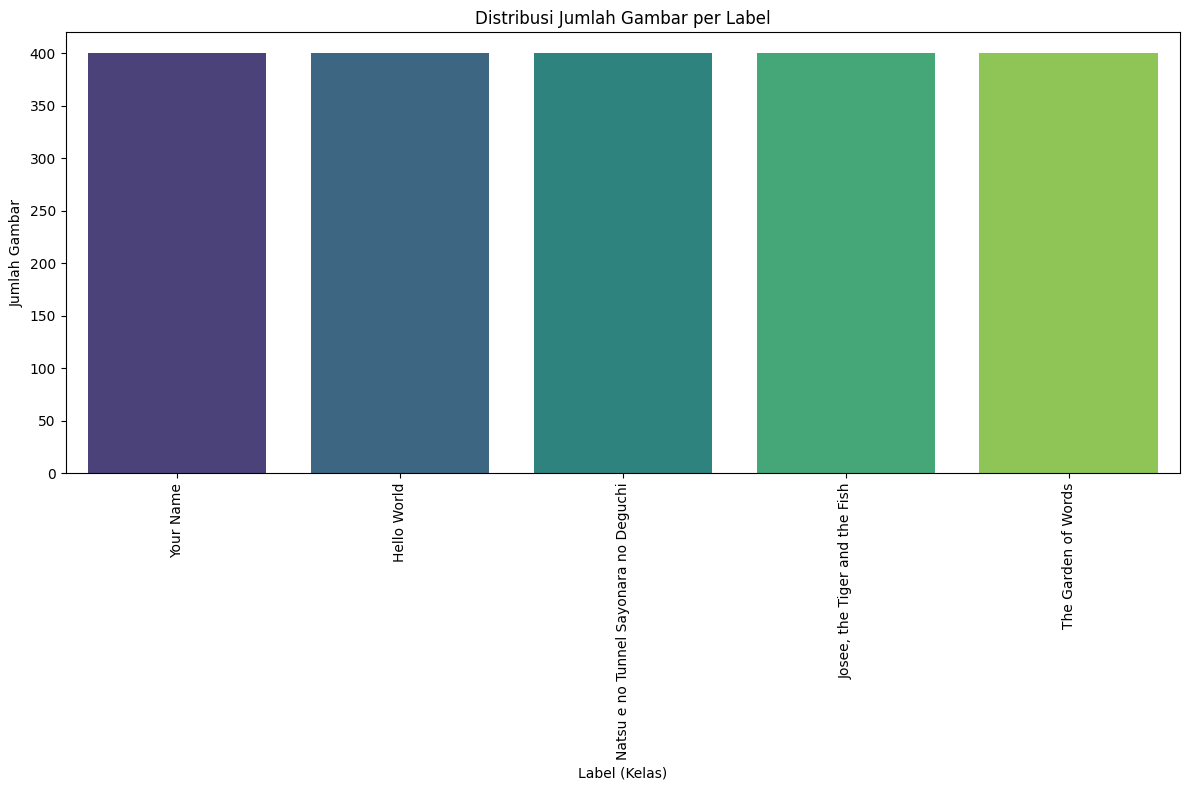

In [10]:
# Hitung jumlah gambar per label
label_counts = df['labels'].value_counts()

# Visualisasi bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Distribusi Jumlah Gambar per Label")
plt.xlabel("Label (Kelas)")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [11]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

In [12]:
path = '/content/Clean_testing/AnimeLens_perframe_clean'
entries = os.listdir(path)

folders = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]

# print(f"Number of folders in '{path}': {len(folders)}")

print("Folder names:")
for folder in folders:
    print(folder)

Folder names:
Your Name
Hello World
Natsu e no Tunnel Sayonara no Deguchi
Josee, the Tiger and the Fish
The Garden of Words


In [13]:
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))
    print(f"{folder}: {num_images} images")

Your Name: 400 images
Hello World: 400 images
Natsu e no Tunnel Sayonara no Deguchi: 400 images
Josee, the Tiger and the Fish: 400 images
The Garden of Words: 400 images


In [14]:
source_path = '/content/Clean_testing/AnimeLens_perframe_clean'

image_dir = Path(source_path)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [15]:
image_df

,Filepath,Label
0,/content/Clean_testing/AnimeLens_perframe_clea...,Your Name
1,/content/Clean_testing/AnimeLens_perframe_clea...,Your Name
2,/content/Clean_testing/AnimeLens_perframe_clea...,Your Name
3,/content/Clean_testing/AnimeLens_perframe_clea...,Your Name
4,/content/Clean_testing/AnimeLens_perframe_clea...,Your Name
...,...,...
1995,/content/Clean_testing/AnimeLens_perframe_clea...,The Garden of Words
1996,/content/Clean_testing/AnimeLens_perframe_clea...,The Garden of Words
1997,/content/Clean_testing/AnimeLens_perframe_clea...,The Garden of Words
1998,/content/Clean_testing/AnimeLens_perframe_clea...,The Garden of Words


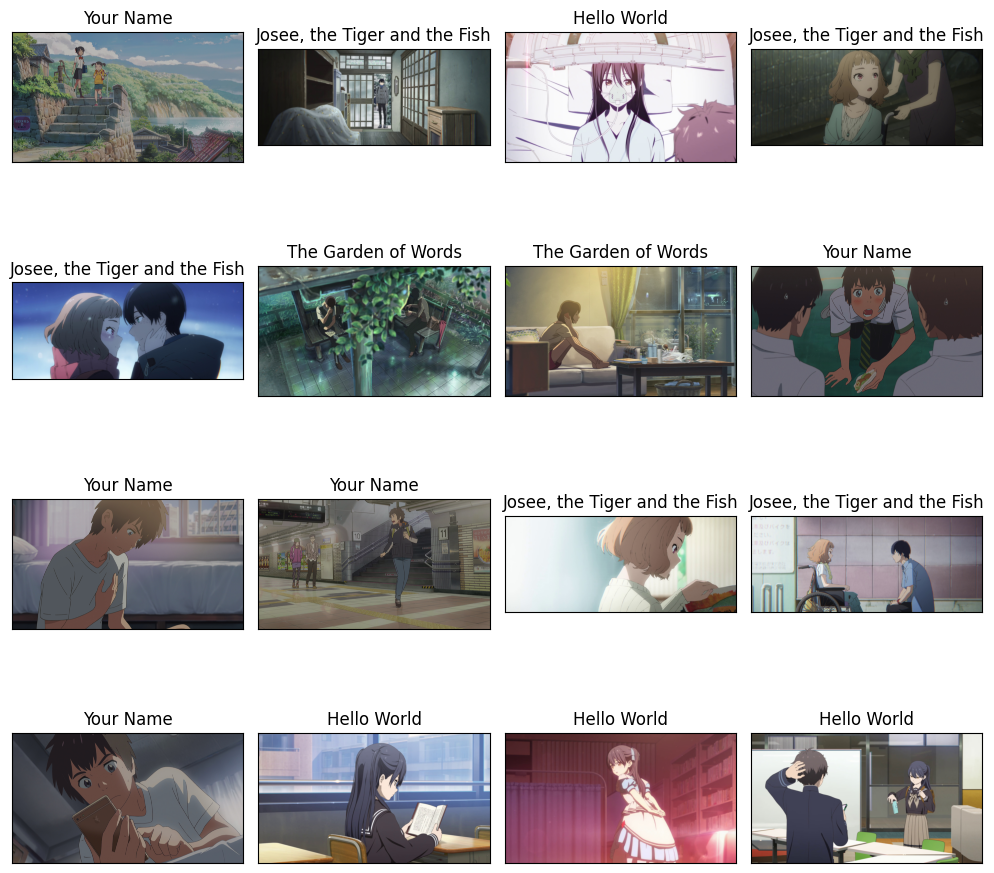

In [16]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [17]:
base_dir = "/content/Clean_testing/AnimeLens_perframe_clean"

image_paths = []
labels = []

for subdir, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith((".jpg", ".jpeg", ".png")):
            file_path = os.path.join(subdir, file)
            image_paths.append(file_path)
            labels.append(os.path.basename(subdir))

# Split dalam train dan test (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Split training kedalam training dan validation (80% train, 20% validation dari train set)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

train_dir = "Train"
test_dir = "Test"
val_dir = "Validation"

for folder in [train_dir, test_dir, val_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(val_dir)

unique_labels = np.unique(labels)

for label in unique_labels:
    os.makedirs(os.path.join(train_dir, label))
    os.makedirs(os.path.join(test_dir, label))
    os.makedirs(os.path.join(val_dir, label))

for train_path, train_label in zip(train_paths, train_labels):
    dest = os.path.join(train_dir, train_label, os.path.basename(train_path))
    shutil.copy2(train_path, dest)


for test_path, test_label in zip(test_paths, test_labels):
    dest = os.path.join(test_dir, test_label, os.path.basename(test_path))
    shutil.copy2(test_path, dest)


for val_path, val_label in zip(val_paths, val_labels):
    dest = os.path.join(val_dir, val_label, os.path.basename(val_path))
    shutil.copy2(val_path, dest)

print("Data sudah displit kedalam folder Train, Test dan Validation.")

Data sudah displit kedalam folder Train, Test dan Validation.


In [18]:
# image data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [19]:
train_images = train_datagen.flow_from_directory(
    directory='/content/Train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_images = val_datagen.flow_from_directory(
    directory='/content/Validation',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

test_images = test_datagen.flow_from_directory(
    directory='/content/Test',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 1280 images belonging to 5 classes.
Found 320 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In [20]:
print("Class indices:", train_images.class_indices)

Class indices: {'Hello World': 0, 'Josee, the Tiger and the Fish': 1, 'Natsu e no Tunnel Sayonara no Deguchi': 2, 'The Garden of Words': 3, 'Your Name': 4}


# Modelling

In [21]:
resize_and_rescale = Sequential([
    Resizing(224, 224),
    Rescaling(1./255),
])

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
], name="data_augmentation")

In [22]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
early_stopping = EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  restore_best_weights=True)

In [25]:
# create model
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [27]:
# compile model
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# training model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=250,
    callbacks=[early_stopping]
)

Epoch 1/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.1936 - loss: 1.7400 - val_accuracy: 0.2250 - val_loss: 1.6288
Epoch 2/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2725 - loss: 1.6322 - val_accuracy: 0.2438 - val_loss: 1.5962
Epoch 3/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2526 - loss: 1.6117 - val_accuracy: 0.2906 - val_loss: 1.5662
Epoch 4/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2724 - loss: 1.6007 - val_accuracy: 0.3219 - val_loss: 1.5392
Epoch 5/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3064 - loss: 1.5408 - val_accuracy: 0.3500 - val_loss: 1.5140
Epoch 6/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2923 - loss: 1.5555 - val_accuracy: 0.3812 - val_loss: 1.4903
Epoch 7/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3450 - loss: 1.5036 - val_accuracy: 0.4031 - val_loss: 1.4678
Epoch 8/250
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3584 - loss: 1.4693 - val_accuracy: 0.4187 - v

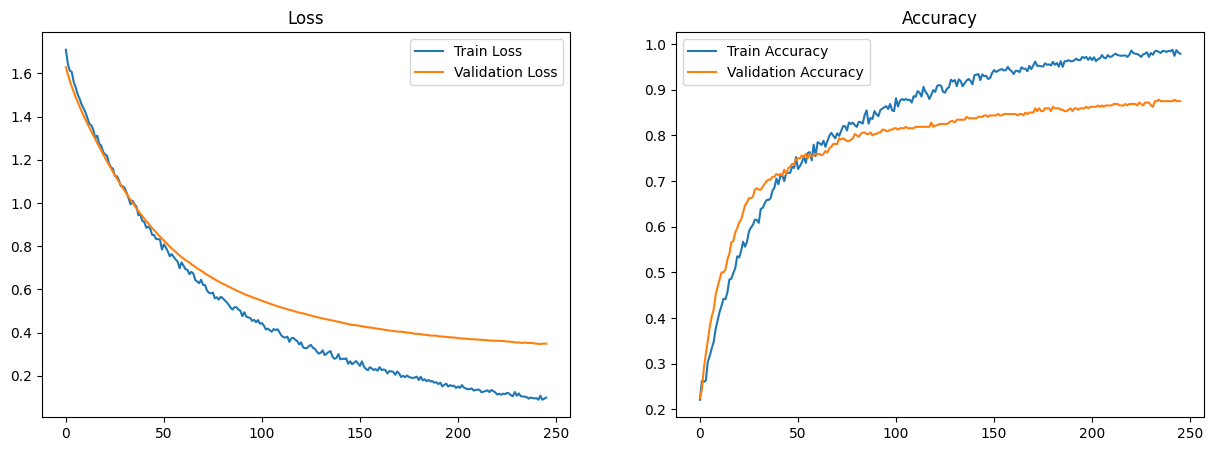

In [28]:
fig, ax = plt.subplots(
    1, 2, figsize=(15, 5)
)

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [29]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.34905
Test Accuracy: 87.00%


In [30]:
from google.colab import files
import shutil

model.save("animelens_model.h5")
model.export("animelens_saved_model")

files.download("animelens_model.h5")
shutil.make_archive("animelens_saved_model", 'zip', "animelens_saved_model")
files.download("animelens_saved_model.zip")

Saved artifact at 'animelens_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138386445434128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445431056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445434320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445433168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445428944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445429328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445430672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386382232976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445428752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386445427600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386382

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inference

In [49]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np

model = tf.saved_model.load("/content/animelens_saved_model")

img_path = "test9.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
img_array = tf.cast(img_array, dtype=tf.float32)

# Access the serving_default signature for inference
infer = model.signatures["serving_default"]

# Perform inference
predictions = infer(img_array)
output_key = list(predictions.keys())[0] # Get the first key from the dictionary
predictions_tensor = predictions[output_key]


predictions_np = predictions_tensor.numpy()


predicted_class_index = np.argmax(predictions_np, axis=1)[0]
confidence = np.max(predictions_np)

class_indices = train_images.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
predicted_class_name = idx_to_class[predicted_class_index]

# Print the results
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")
print(f"Confidence: {confidence:.2f}")

Predicted class index: 3
Predicted class name: The Garden of Words
Confidence: 0.95
